In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
stock_list = ['2317', '2330', '3008']

stock_r = pd.DataFrame() # [stock] [r]eturns

for stock_name in stock_list:
    df = pd.read_csv(stock_name + '.csv', header=None)
    df = df[[0, 6]]
    df.columns = ['date', 'close']
    taiwan_date = df['date'].str.split('/', expand=True)
    years = taiwan_date[0].astype(int) + 1911
    df['date'] = years.astype(str) + '/' + taiwan_date[1] + '/' + taiwan_date[2]
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H:%M:%S')
    df['close'] = df['close'].replace('--', np.nan).astype(float) # replace '--' with NaN is pretty weird. I think 0 is a better candidate.
    df = df[ (df['date'] > '2015') & (df['date'] < '2017') ]
    df['return'] = df['close'].pct_change().fillna(0)
    df.index = df['date'] # if this step is omitted NaN will appear. Why? Because the indices are different from three data, they will only become the same should we make them the dates.
    stock_r = pd.concat( [ stock_r, df['return'] ], axis=1 )
    
stock_r.columns = stock_list
stock_r.head()

,2317,2330,3008
2015-01-05 00:00:00,0.000000,0.000000,0.000000
2015-01-06 00:00:00,-0.030963,-0.043011,-0.031915
2015-01-07 00:00:00,0.008284,0.003745,0.010989
2015-01-08 00:00:00,0.019953,0.029851,0.028261
2015-01-09 00:00:00,-0.004603,-0.028986,-0.010571


In [3]:
stock_r = stock_r[1:]
stock_r.head()

,2317,2330,3008
2015-01-06 00:00:00,-0.030963,-0.043011,-0.031915
2015-01-07 00:00:00,0.008284,0.003745,0.010989
2015-01-08 00:00:00,0.019953,0.029851,0.028261
2015-01-09 00:00:00,-0.004603,-0.028986,-0.010571
2015-01-12 00:00:00,-0.009249,-0.014925,-0.008547


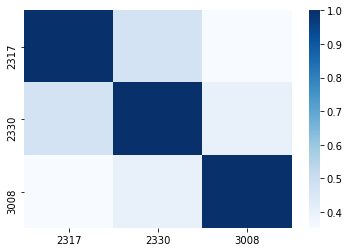

In [4]:
sns.heatmap(stock_r.corr(), cmap='Blues')

In [5]:
stock_expected_r = stock_r.mean() * 252 # [stock] [expected] [r]eturns
stock_expected_r

2317    0.008656
2330    0.165958
3008    0.355043
dtype: float64

In [6]:
stock_covariance_matrix = stock_r.cov() * 252
stock_covariance_matrix

,2317,2330,3008
2317,0.052986,0.026570,0.037776
2330,0.026570,0.059732,0.045850
3008,0.037776,0.045850,0.216272


In [7]:
stock_len = len(stock_list) # [stock] [len]gth
stock_weights = np.array([1/stock_len for i in range(stock_len)])
stock_weights

array([0.33333333, 0.33333333, 0.33333333])

In [8]:
portfolio_return = sum(stock_weights * stock_expected_r)
portfolio_return

0.1765523294924345

In [9]:
portfolio_risk = np.sqrt( np.dot( np.dot(stock_weights, stock_covariance_matrix), stock_weights.T ) )
portfolio_risk

0.2470677648619172

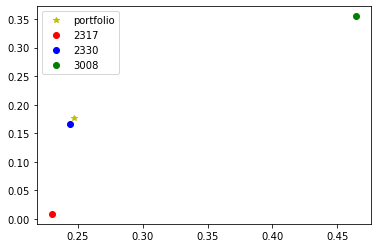

In [10]:
plt.plot(portfolio_risk, portfolio_return, 'y*', label='portfolio')
plt.plot( np.sqrt( np.var(stock_r['2317']) * 252 ), stock_expected_r[0], 'ro', label='2317' )
plt.plot( np.sqrt( np.var(stock_r['2330']) * 252 ), stock_expected_r[1], 'bo', label='2330' )
plt.plot( np.sqrt( np.var(stock_r['3008']) * 252 ), stock_expected_r[2], 'go', label='3008' )
plt.legend()

In [11]:
rsk = [] # [r]i[sk]
rtn = [] # [r]e[t]ur[n]
for _ in range(1000):
    w = np.random.rand(stock_len)
    w /= sum(w)
    rtn.append( sum(stock_expected_r * w) )
    rsk.append( np.sqrt( np.dot( np.dot(w, stock_covariance_matrix), w.T ) ) )

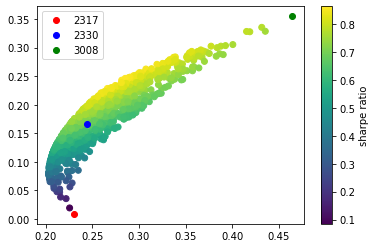

In [12]:
sc = plt.scatter( rsk, rtn, c=( np.array(rtn) / np.array(rsk) ) ) # [sc]atter plot
plt.colorbar(sc, label='sharpe ratio')
plt.plot( np.sqrt( np.var(stock_r['2317']) * 252 ), stock_expected_r[0], 'ro', label='2317' )
plt.plot( np.sqrt( np.var(stock_r['2330']) * 252 ), stock_expected_r[1], 'bo', label='2330' )
plt.plot( np.sqrt( np.var(stock_r['3008']) * 252 ), stock_expected_r[2], 'go', label='3008' )
plt.legend()

In [13]:
import scipy.optimize as solver

def std(w): # [st]an[d]ard deviation
    return np.sqrt( np.dot( np.dot(w, stock_covariance_matrix), w.T ) )

def output_weight(rt): # [r]eturn [r]ate
    x0 = np.array( [1/stock_len for i in range(stock_len)] )
    bounds = tuple( (0, 1) for x in range(stock_len) )
    constraints = [
        {'type': 'eq', 'fun': lambda x: sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: sum(x * stock_expected_r) - rt}
    ]
    out = solver.minimize(std, x0=x0, constraints=constraints, bounds=bounds)
    return out

print('最佳化 0.18 報酬的權重：', output_weight(.18).x)

最佳化 0.18 報酬的權重： [0.13746882 0.67390561 0.18862557]


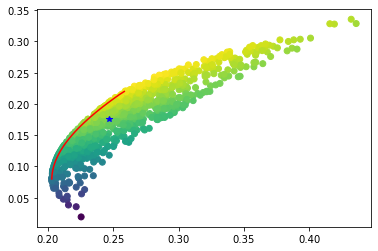

In [14]:
risk = []
given_r = np.arange(.08, .22, .005) # [given] [r]ange
for i in given_r:
    risk.append(output_weight(i).fun)

sc = plt.scatter( rsk, rtn, c=( np.array(rtn) / np.array(rsk) ) )
plt.plot(risk, given_r, '-', color='red')
plt.plot(portfolio_risk, portfolio_return, 'b*')